In [4]:
# this is an input-output file, which takes the fits file as an input and gives us a white image of the data cube by suming all the values of the wavelength axis
# importing the required libraries
from musetools import io as io
import matplotlib.pyplot as plt
from musetools import spec as s
import numpy as np
import getpass
from astropy.convolution import Gaussian2DKernel, convolve
from matplotlib import mlab, cm

from copy import deepcopy

%matplotlib inline
username=getpass.getuser()

if username == 'bordoloi':
	fitsfile = '/Users/bordoloi/Dropbox/MUSE/LensedArc/RCS0327_16mc_zap.fits'
else:
	fitsfile = '/home/ahmed/astro/data/RCS0327_16mc_zap.fits'
#input("Enter the path to your file: ")


wave, data, var, header = io.open_muse_cube(fitsfile)
#w = WCS(header)
zgal= 1.7037455
wrest = wave/(1.+zgal)

#spec, spec_err = s.extract_square(115, 237, wave, data, var, 5)
minwave = 7558.4#7090.     #7090.       #7555.
maxwave = 7563.7#7110.     #7110.       #7573.
ems_image = io.narrow_band(minwave, maxwave, wave, data,plot=False)
cont_min = 7645.#6930.
cont_max = 7650.5#6950.
cont_image = io.narrow_band(cont_min, cont_max, wave, data,plot=False)


wl_min = 6500.#6930.
wl_max = 8500.5#6950.
wl_image = io.narrow_band(wl_min, wl_max, wave, data,plot=False)


residual_image=ems_image-cont_image

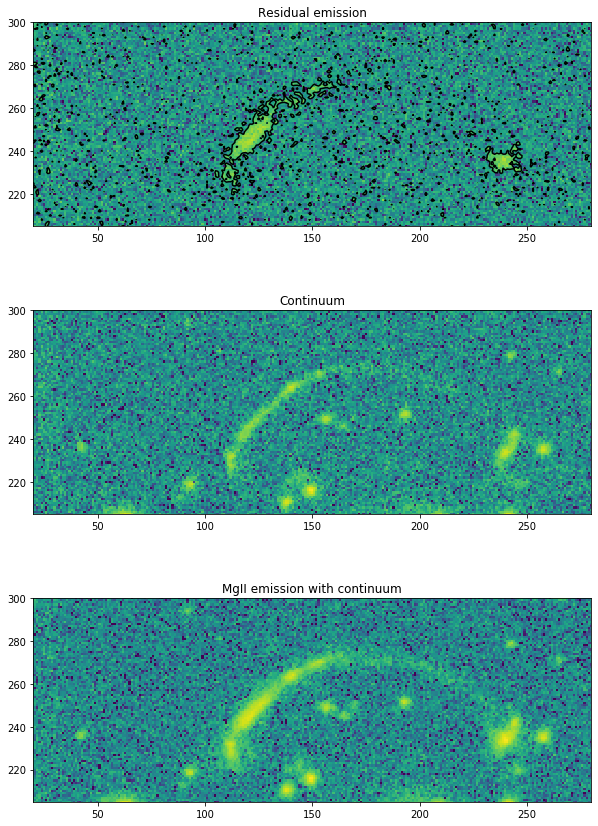

'\nThe z stretching for the color map\n'

In [2]:

'''
The z stretching for the color map
'''

zmin=-1
zmax=2.

width_in = 10
fig=plt.figure(1, figsize=(width_in, 15))
ax = fig.add_subplot(311)
ax.imshow(np.log10(np.abs( residual_image)), cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
ax.contour(ems_image-cont_image,levels=np.logspace(1,3,3),colors='black')
ax.set_title('Residual emission')
ax.set_ylim([205,300])
ax.set_xlim([20,280])


ax1 = fig.add_subplot(312)
ax1.imshow(np.log10(np.abs(cont_image )), cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
ax1.set_title('Continuum')
ax1.set_ylim([205,300])
ax1.set_xlim([20,280])



ax2 = fig.add_subplot(313)
ax2.imshow(np.log10(np.abs(ems_image)), cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
ax2.set_title('MgII emission with continuum')
ax2.set_ylim([205,300])
ax2.set_xlim([20,280])

plt.show()

#fig = plt.figure()
'''
The z stretching for the color map
'''


## Now start the actual ROI finding

In [65]:

def smooth_image(image,stddev=1.4,sig_threshold=3.,sky_x=[240,280],sky_y=[40,100]):
    #-----------------------------------------------
    # This is a quick wrapper to compute a region of interest of certain emission strength. 
    # 
    # Input:- 
    #        image = image matrix
    #        stddev = standard deviation of the smoothing Gaussian kernel
    #        sig_threshold  = sigma threshold above which emission is detected
    #        sky_x, sky_y =  x,y coordinates to chose the background space. 
    #
    # Output:- 
    #        Final_Image =  Image with region of interest, every other pixel value = 0
    #
    #------------------------------------------------
    
    # We smooth with a Gaussian kernel with stddev=2
    # It is a 9x9 array
    if stddev >0:
        kernel = Gaussian2DKernel(x_stddev=stddev)
        # create a "fixed" image with NaNs replaced by interpolated values
        # astropy's convolution replaces the NaN pixels with a kernel-weighted
        # interpolation from their neighbors
        astropy_conv = convolve(image, kernel)
    else:
        astropy_conv =image
            

        
    mean_val=(np.mean(astropy_conv))
    std_val=(np.std(astropy_conv[sky_x[0]:sky_x[1],sky_y[0]:sky_y[1]]))
    
    qq=np.where((astropy_conv < sig_threshold*std_val))
    qq_complement=np.where((astropy_conv >= sig_threshold*std_val))
    ROI=deepcopy(astropy_conv)
    ROI[qq]= 0.
    #Now create a mask 
    Mask=deepcopy(astropy_conv)
    Mask[qq_complement]=1.
    Mask[qq]=0.
    
    return ROI*Mask


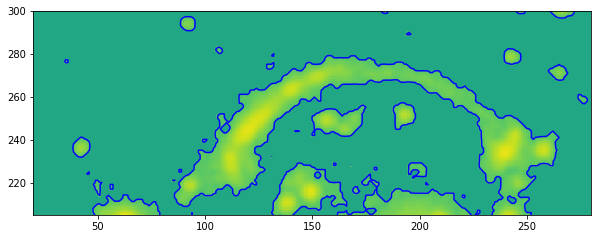

In [66]:

Final_Image=smooth_image(ems_image,stddev=1.4,sig_threshold=3.,sky_x=[260,280],sky_y=[40,100])
Final_Image1=smooth_image(cont_image,stddev=1.4,sig_threshold=3.,sky_x=[260,280],sky_y=[40,100])

Final_Image= Final_Image+1.

ydim, xdim = Final_Image.shape

zmin=-3
zmax=2.

x = np.arange(0., xdim, 1.)
y = np.arange(0., ydim, 1.)
X, Y = np.meshgrid(x, y)
levels = 0.+np.arange(1., 3.601, 2)  # Boost the upper limit to avoid truncation errors.
norm = cm.colors.Normalize(vmax=abs(Final_Image).max(), vmin=(Final_Image).min())

width_in = 10
fig=plt.figure( figsize=(width_in, 15))
ax = fig.add_subplot(111)

lbg=ax.imshow(np.log10(np.abs(Final_Image)),cmap=plt.get_cmap('viridis'),origin="lower",vmin=zmin, vmax=zmax)
ax.set_ylim([205,300])
ax.set_xlim([20,280])



#CS = plt.contour(X, Y, lya_map,levels,norm=norm,cmap='plasma')
CS = plt.contour(X, Y, Final_Image,[-2.,4.],norm=norm,cmap='winter')


#p = CS.collections[0].get_paths()[0]
#v = p.vertices
#x = v[:,0]
#y = v[:,1]
#plt.plot(x,y,'r')
#plt.xlim(x1)
#plt.ylim(x2)





/Users/bordoloi/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(FigureCanvasNbAgg).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


FigureCanvasNbAgg()

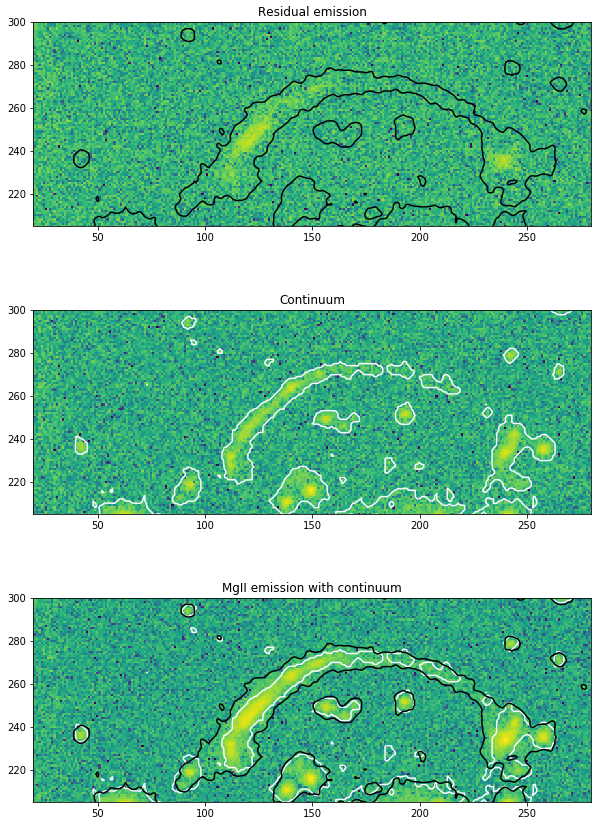

In [71]:

zmin=-2
zmax=2.

zscale=[0.7,10.]
width_in = 10
fig=plt.figure(1, figsize=(width_in, 15))
ax = fig.add_subplot(311)
ax.imshow(np.log10(np.abs(residual_image)), cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
#CS1  = plt.contour(X, Y, np.log10(np.abs(1.+Final_Image1)),zscale,norm=norm,cmap=plt.get_cmap('Blues'))
CS = plt.contour(X, Y, np.log10(np.abs(Final_Image)),zscale,norm=norm,cmap='magma')

ax.set_title('Residual emission')
ax.set_ylim([205,300])
ax.set_xlim([20,280])


ax1 = fig.add_subplot(312)
ax1.imshow(np.log10(np.abs(cont_image )), cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
CS1  = plt.contour(X, Y, np.log10(np.abs(1.+Final_Image1)),zscale,norm=norm,cmap=plt.get_cmap('Blues'))
#CS = plt.contour(X, Y, np.log10(np.abs(Final_Image)),zscale,norm=norm,cmap='magma')

ax1.set_title('Continuum')
ax1.set_ylim([205,300])
ax1.set_xlim([20,280])



ax2 = fig.add_subplot(313)
ax2.imshow(np.log10(np.abs(ems_image)), cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
CS1  = plt.contour(X, Y, np.log10(np.abs(1.+Final_Image1)),zscale,norm=norm,cmap=plt.get_cmap('Blues'))
CS = plt.contour(X, Y, np.log10(np.abs(Final_Image)),zscale,norm=norm,cmap='magma')

ax2.set_title('MgII emission with continuum')
ax2.set_ylim([205,300])
ax2.set_xlim([20,280])

plt.show()


In [6]:
aa=deepcopy(wl_image[205:300,80:260])

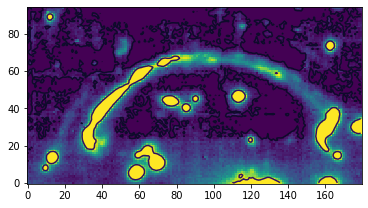

In [7]:
plt.imshow(aa, cmap = plt.get_cmap('viridis'), origin='lower',vmin=0,vmax=3600)

zscale=[10.,3600.]

ydim, xdim = aa.shape
x = np.arange(0., xdim, 1.)
y = np.arange(0., ydim, 1.)
X, Y = np.meshgrid(x, y)
levels = 0.+np.arange(1., 36000.601, 10)  # Boost the upper limit to avoid truncation errors.
norm = cm.colors.Normalize(vmax=aa.max(), vmin=aa.min())

CS = plt.contour(X, Y, aa,zscale,norm=norm,cmap='magma')


/Users/bordoloi/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(FigureCanvasNbAgg).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


FigureCanvasNbAgg()

(array([29., 49., 40., 20., 17., 12.,  3.,  4.,  2.,  4.]),
 array([  2266.0837,  29757.229 ,  57248.375 ,  84739.516 , 112230.664 ,
        139721.81  , 167212.95  , 194704.1   , 222195.23  , 249686.39  ,
        277177.53  ], dtype=float32),
 <a list of 10 Patch objects>)

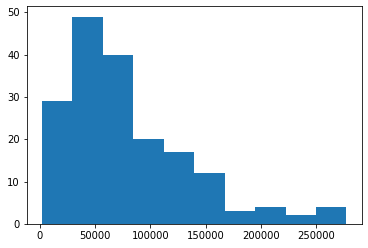

In [96]:
plt.hist(np.sum(aa,axis=0))

In [97]:
print(np.max(np.max(aa)))

36420.77


/Users/bordoloi/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(FigureCanvasNbAgg).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


FigureCanvasNbAgg()

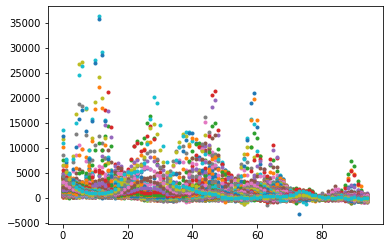

In [98]:
for i in range(0,160):
    plt.plot(aa[:,i],'.')
    

/Users/bordoloi/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(FigureCanvasNbAgg).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


FigureCanvasNbAgg()

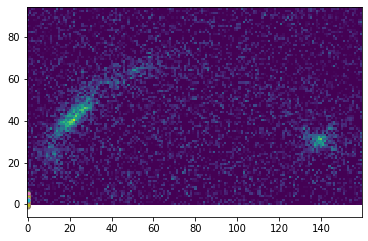

In [40]:
#plt.imshow(aa, cmap = plt.get_cmap('viridis'), origin='lower',vmin=1,vmax=60)

for i in range(0,160):
    plt.plot(np.mean(aa[:,i]),'.')
    


In [99]:
from astropy.io import fits

In [100]:
hdu = fits.PrimaryHDU(aa) 
hdul = fits.HDUList([hdu]); hdul.writeto('/Users/bordoloi/Desktop/new.fits')

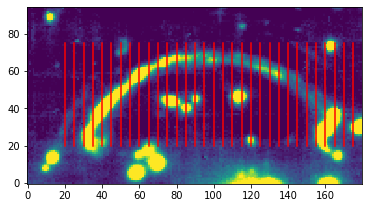

In [24]:
xgrid=np.arange(20,180,5)

plt.imshow(aa, cmap = plt.get_cmap('viridis'), origin='lower',vmin=1,vmax=3600)


for i in xgrid:
    plt.plot([i,i],[20,75],'r-')

In [169]:
def trace_image(image,xgrid):
    
    for i in range(1,len(xgrid)):
        # find all indices inside the grid values
        q= image[20:75,xgrid[i-1]:xgrid[i]]
        plt.plot(np.sum(q,axis=1),'.')
        tq=np.sum(q,axis=1)
        #medIdx = tq.index(np.percentile(tq,50,interpolation='nearest'))
        print(tq)
        


        
ygrid=np.arange(0,30,1)  
len(tq)

55

(array([41]),)


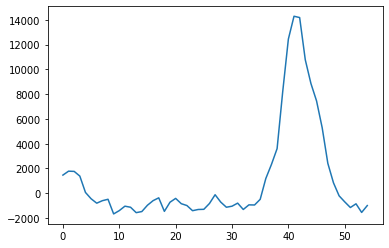

In [170]:

i=22
q= aa[20:75,xgrid[i-1]:xgrid[i]]
tq=np.sum(q,axis=1)

plt.plot(tq)
qq=np.where(tq==np.max(tq))
print(qq)

In [3]:
trace_image(aa,xgrid)

NameError: name 'trace_image' is not defined

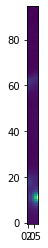

In [18]:
i=10
q= aa[:,xgrid[i-1]:xgrid[i]]
plt.imshow(q,origin='lower')

In [119]:
ymin_lin=np.ones((len(xgrid,)))
p=-20
k=100
h=60
ymin=55+-0.01* (xgrid-100)**2
ymin[ymin<0]=20

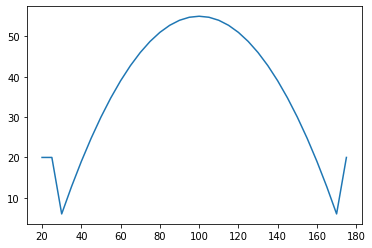

In [120]:
plt.plot(xgrid,ymin)

(0, 100)

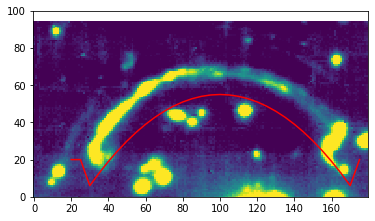

In [121]:
plt.imshow(aa, cmap = plt.get_cmap('viridis'), origin='lower',vmin=1,vmax=3600)
plt.plot(xgrid,ymin,'r')
plt.ylim([0,100])

In [122]:
import random
import numpy as np
#some random list with 20 elements
a = [random.random() for i in range(20)]
#find the median index of a
medIdx = a.index(np.percentile(a,50,interpolation='nearest'))

In [123]:
medIdx

3

In [124]:
a

[0.4623653146720478,
 0.6469676730343198,
 0.35150775378933563,
 0.4282238473180793,
 0.309360555337978,
 0.707512225016297,
 0.7947577161548034,
 0.9959192671730155,
 0.40524319540023634,
 0.06298374320706968,
 0.04722303294985353,
 0.5862947444705049,
 0.38198297272978454,
 0.9936234140048956,
 0.6886128794803603,
 0.2212069724585587,
 0.40481065201644983,
 0.3390757008893288,
 0.9517622272650266,
 0.40185732858898604]

In [1]:
from matplotlib.path import Path
import numpy as np
tupVerts=[(86, 52), (85, 52), (81, 53), (80, 52), (79, 48), (81, 49), (86, 53),
 (85, 51), (82, 54), (84, 54), (83, 49), (81, 52), (80, 50), (81, 48),
 (85, 50), (86, 54), (85, 54), (80, 48), (79, 50), (85, 49), (80, 51),
 (85, 53), (82, 49), (83, 54), (82, 53), (84, 49), (79, 49)]


x, y = np.meshgrid(np.arange(300), np.arange(300)) # make a canvas with coordinates
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T 

p = Path(tupVerts) # make a polygon
grid = p.contains_points(points)
mask = grid.reshape(300,300) # now you have a mask with points inside a polygon

In [2]:
plt.imshow(mask)

NameError: name 'plt' is not defined